<a href="https://colab.research.google.com/github/dlskawns/cp1/blob/main/review_analysis3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 주제: 

#### 딥러닝을 이용한 리뷰기반 고객탐색 및 추천 알고리즘

<br>

딥러닝 모델을 통해 이커머스 데이터의 마케팅적 분석을 진행하고 리뷰를 분석하여, 문제요소를 찾아 개선하고 이를 바탕으로 고객을 세분화하여 타겟에 더욱 적합한 추천시스템을 적용하는 것을 목표로 합니다.


### 필요 모듈 가져오기 

In [ ]:
!pip install squarify
!pip install transformers
!pip install category_encoders
!pip install sentence-transformers

In [3]:
from google.colab import drive
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFBertModel, BertConfig, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings(action='ignore')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

### 데이터 불러오기

* 구글 드라이브의 폴더 및 파일을 접근하기 위해 마운트 합니다.

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reviews_project2.csv')
df.rename(columns={'Summary ':'Summary'}, inplace=True)

In [ ]:
df['Summary'].fillna('', inplace=True)

In [6]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## 1. EDA 및 특성공학

각 Features의 특징을 면밀히 체크합니다.

특히 Funnel 분석을 위해선 최종적으로 재구매 주기 및 재구매가 줄어든 시점을 파악해봅니다.

In [ ]:
# 수치 데이터 파악
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
#결측치 확인
df.isnull().sum()

Id                             0
ProductId                      0
UserId                         0
ProfileName                   16
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                          0
Time                           0
Summary                       27
Text                           0
date                           0
dayofweek                      0
r_counts                       0
keyword                        0
labels                    475716
pet                            0
dtype: int64

In [7]:
# 요약부분 결측치 str 구조로 대체
df['Summary'].fillna('', inplace = True)

df['ProfileName'].fillna('', inplace = True)

---

특성 생성 1. 

타임스탬프 데이터를 통해 리뷰 작성 날짜 인사이트를 파악해봅니다.

해당 날짜를 'date' feature를 생성해 샘플별로 저장합니다.

* 날짜를 통해 고객의 재구매까지 걸리는 기간을 파악 가능
* 날짜 별 분포를 통해 고객 리뷰의 날짜별 패턴 유무 파악 가능

In [ ]:
# 날짜를 변경
df['date'] = pd.to_datetime(df['Time'], unit = 's')
df

---

특성 생성 2.

해당 datetime 형식의 'date' feature에서 더 나아가 요일 데이터를 파악해 feature로 만들어 봅니다.

calendar 모듈을 이용해 변경 및 'dayofweek' feature를 생성 및 저장합니다.

* 요일 별 고객 구매행동의 패턴 유무를 파악합니다.

In [36]:
import calendar

# 요일 특성 생성

df['dayofweek'] = df['date'].map(lambda x: calendar.day_name[x.weekday()])


---

#### 요일 및 별 리뷰 수 분포 

* 주말에 리뷰가 적고 평일에 리뷰 수가 많음.

* 날짜 별 분포로는 전체 중 2012년도에 데이터가 가장 많음  
특별히 더 얻을 정보는 없어 보임

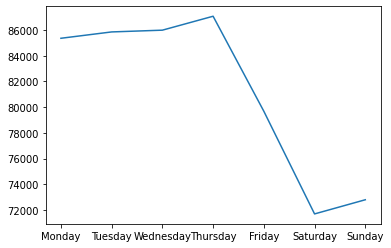

In [ ]:
# 요일 별 리뷰 수 분포
c = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.plot(df['dayofweek'].value_counts().reindex(c).index, df['dayofweek'].value_counts().reindex(c).values);

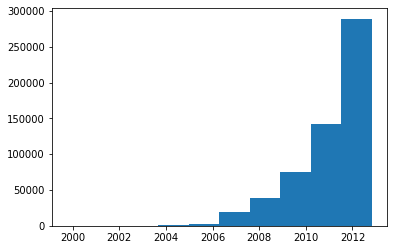

In [ ]:
# 날짜 별 리뷰 수 분포
# plt.bar(df['date'].value_counts().index, df['date'].value_counts().values);
plt.hist(df['date']);
plt.show()

---

특성 생성 3. 

유저 별 리뷰 수를 나타내는 feature를 생성합니다.

* Unique한 UserId 당 몇 개의 샘플을 갖고 있는지 확인 가능  
이를 통해 충성고객 여부 또는 재구매 관련 분석 진행 가능

In [ ]:
# 유저별 리뷰 수 칼럼 생성
df_re = df['UserId'].value_counts().reset_index()
df_re.columns = ['UserId','r_counts']
df = df.join(df_re.set_index('UserId')['r_counts'], on='UserId')

---

#### 유저, 리뷰수, 평점 관계 분포

\* <small> 모든 고객이 상품 구매 후 100% 리뷰를 작성했다고 가정 (리뷰가 없는 데이터가 따로 없으므로)</small>


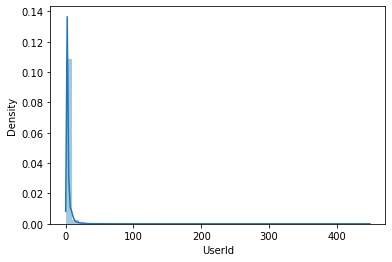

In [ ]:
# 유저 별 리뷰 수 분포
sns.distplot(df['UserId'].value_counts());

In [ ]:
# 리뷰수 구간 별 유저 수
print('리뷰 수 1: ',len(df[df['r_counts']==1]['UserId'].unique()))
print('리뷰 수 2~100: ',len(df[(df['r_counts']<=100) & (df['r_counts'] > 1)]['UserId'].unique()))
print('리뷰 수 100~: ',len(df[df['r_counts'] >= 1]['UserId'].unique()))


리뷰 수 1:  175391
리뷰 수 2~100:  80605
리뷰 수 100~:  256059


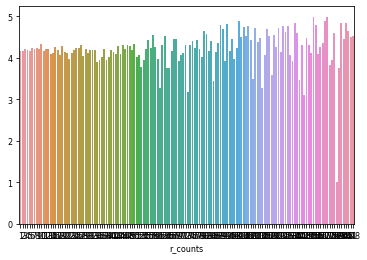

In [ ]:
# 리뷰수 별 평균 평점 > 리뷰를 조금 달았다고 꼭 스코어가 낮은 것은 아니다.

sns.barplot(df.groupby('r_counts')['Score'].mean().index, df.groupby('r_counts')['Score'].mean().values);

plt.show();

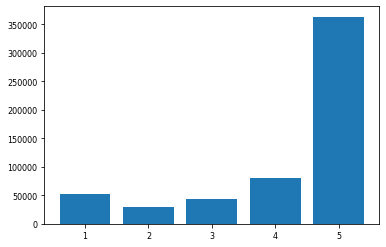

In [ ]:
# 스코어 분포 파악
plt.bar(df['Score'].value_counts().index, df['Score'].value_counts().values);


* 1~30개 정도의 리뷰를 쓴 유저가 가장 많음 >> 구매 불만족으로 인해 리뷰 수(재구매)가 적은 것인지 의문
* 리뷰 수 별 고객 평균 평점분포 확인 >> 리뷰 수가 적다고 평점이 낮지 않음. 고객 이탈과 연관짓기 어려움
* 전체 데이터의 점수 분포 파악 >> 5점이 압도적으로 많아 스코어를 통해 고객 이탈원인 파악이 쉽지 않음

---

#### 리뷰 TOP 10의 개수 및 평점 파악

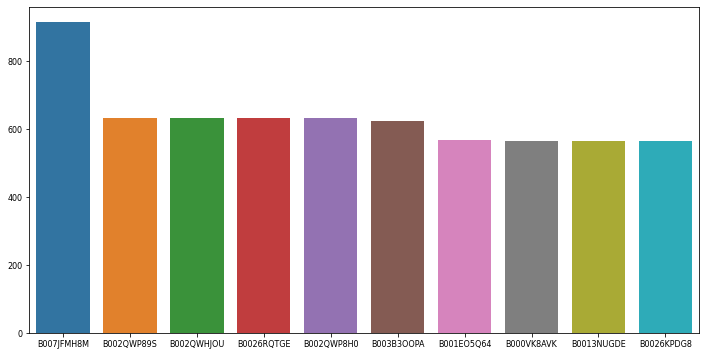

In [ ]:
# 리뷰가 가장 많은 상품 TOP 10 리뷰 개수
product_most = df['ProductId'].value_counts()[:10]
plt.figure(figsize=(12,6))

plt.rc('font', size=8)        # 기본 폰트 크기
sns.barplot(product_most.index, product_most.values);
plt.title('Reviews Top 10')
plt.show();

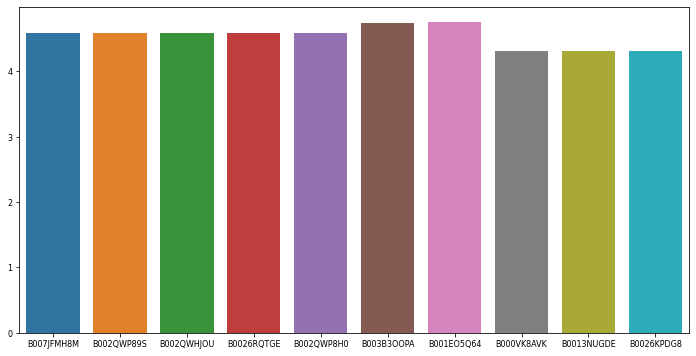

In [ ]:
# 리뷰수 top 10의 스코어 평균 파악
products10_score=[]
for i in range(len(product_most.index)):
  products10_score.append(round(df[df['ProductId']==(product_most.index)[i]]['Score'].mean(),2))
plt.figure(figsize=(12,6))
sns.barplot(product_most.index, products10_score);
plt.rc('font', size=8)        # 기본 폰트 크기
plt.show();

#### (3점 미만의) 리뷰 TOP 10의 개수 및 평점 파악

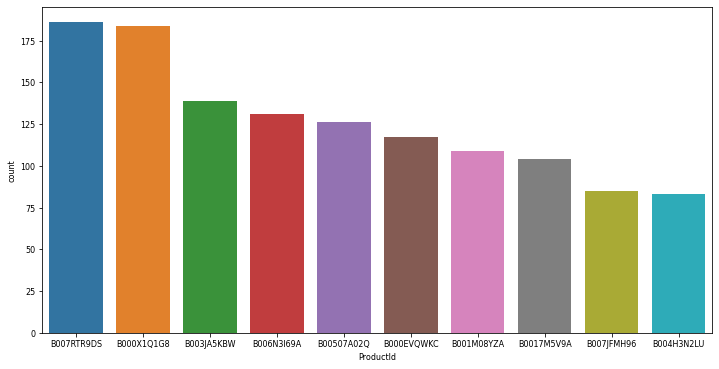

In [ ]:
# 평점이 낮은 상품(3미만)중 리뷰가 많은 상품 개수
plt.figure(figsize=(12,6))
sns.barplot(product_cnt_low_scored.index, product_cnt_low_scored['count']);
plt.rc('font', size=8)        # 기본 폰트 크기
plt.show();

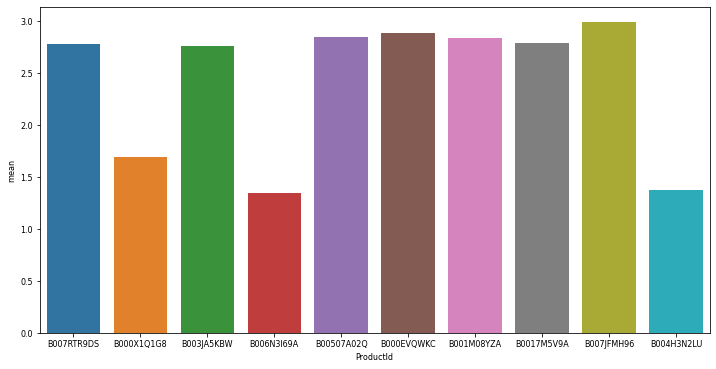

In [ ]:
# 평점이 낮은 상품(3미만)중 리뷰가 많은 상품 평점 평균
product_cnt_low_scored = df.groupby('ProductId')['Score'].agg(['count', 'mean']).sort_values(ascending=False, by= 'count' )
product_cnt_low_scored = product_cnt_low_scored[product_cnt_low_scored['mean']<3][:10]
plt.figure(figsize=(12,6))
sns.barplot(product_cnt_low_scored.index, product_cnt_low_scored['mean']);
plt.rc('font', size=8)        
plt.show();

* 5점을 준 케이스가 많아 TOP 10 상품의 리뷰수 자체가 3점 미만 TOP 10보다 약 4배이상 차이 발생.
* 평점 평균도 큰 의미가 없음

---

특성 생성 5. 

재구매까지 걸리는 기간을 체크합니다.  
같은 고객에 대한 샘플의 날짜 별 정렬을 통해 직전에 구매한 날짜로부터 리뷰작성 당시까지의 기간을 계산

* 고객의 구매 행태 등 관련 인사이트 도출 가능

In [ ]:

# 3. 이전 구매이후 재구매까지 걸린 기간 
day_list = []
df = df[df['r_counts']>1].sort_values(by = ['UserId', 'Time']).reset_index()
for i in range(len(df)):
  print(i)
  if i == 0:
    day_list.append(0)
  elif (df['UserId'][i] == df['UserId'][i-1]) & (df['date'][i] != df['date'][i-1]):
    k = df['date'][i] - df['date'][i-1]
    day_list.append(k.days)
  else:
    day_list.append(0)
df['day_reorder']= day_list

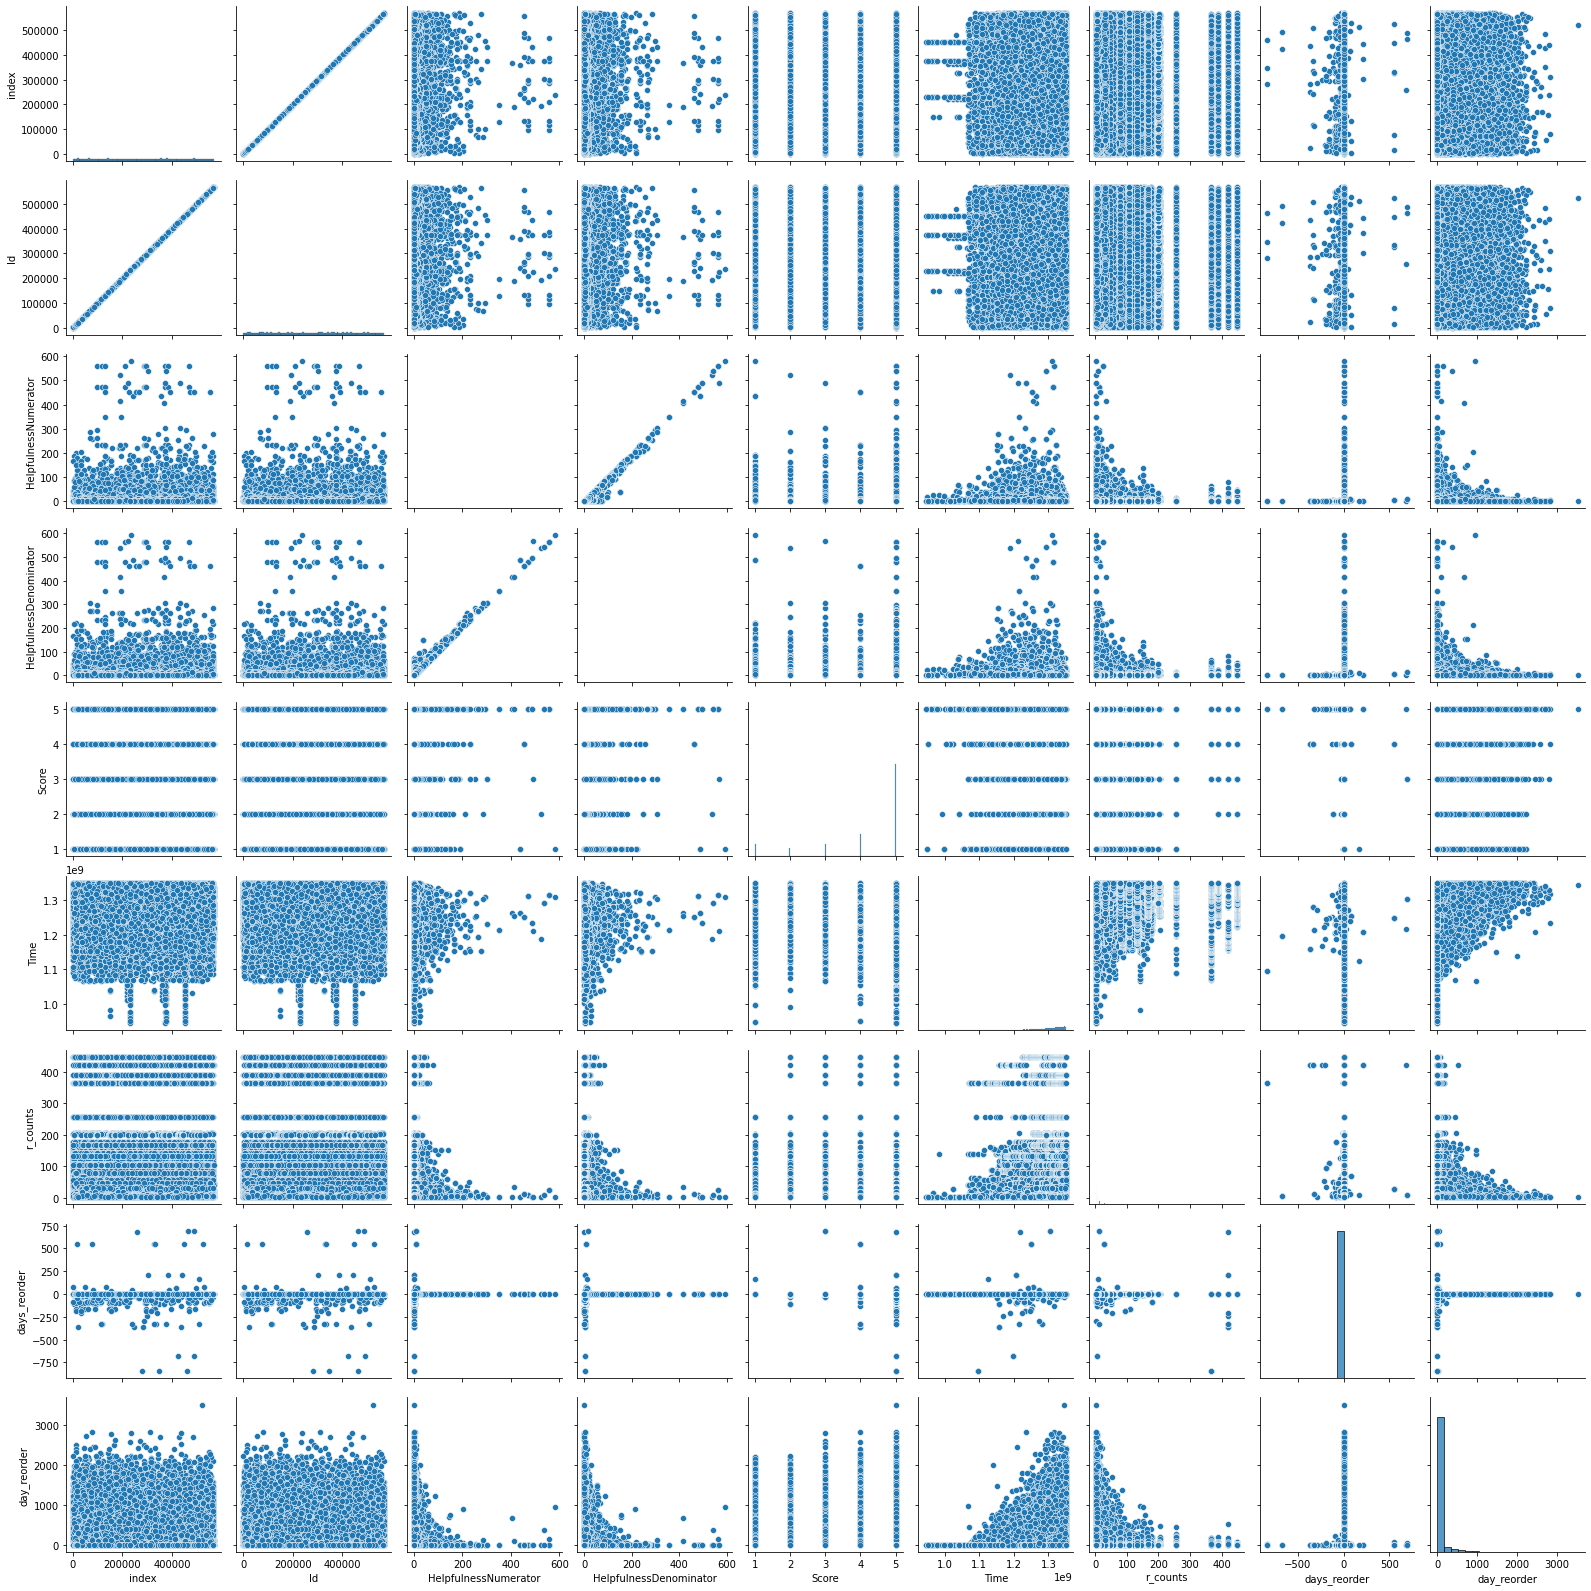

In [ ]:
# 페어플랏을 통해 전체 특성들의 상관관계 한눈에 파악
sns.pairplot(data= df)

* day_reorder(재구매까지의 기간)이 낮을 수록 r_counts(리뷰 개수)가 높다.
* day_reorder(재무개까지의 기간)이 낮을 수록 Helpfulness(리뷰 추천 수)가 높다.
> = r_counts(리뷰 개수)가 높은 사람의 리뷰일 수록 Helpfulness(리뷰 추천 수)가 높다.

리뷰 개수가 높은 사람의 리뷰는 신뢰성이 높은 내용일 가능성이 높으므로  
해당 고객의 상품 리뷰 및 평점, 추후에 생성할 키워드 등을 면밀이 분석해 문제의 원인을 찾거나 마케팅 요소를 발견할 수 있음  

---

## 2. Text 분석

### 특징 키워드 분석을 위해 Tokenizing합니다.

* 아래 BertTokenizer를 사용할 예정이지만, EDA로 사용하기에 nltk 모듈의 함수가 다양하므로 nltk로 토큰화를 합니다.  
(ex: most_common, FreqDist 등)
* 몇 차례 반복하면서 TOP50 내의 단어 중 무의미한 단어들을 갖고 있다면 불용어로 처리했습니다.

In [8]:
# EDA를 위한 불용어 사전 추가

stop_words = stopwords.words('english')
stop_words.extend(['i',
 'me','my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
 "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
 "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',
 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same',
 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
 "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
 "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
 "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", '',
 'found','s', 'br',' would', 'nt','one', 'product', 'also','amazon','much','really','time','find','tried',
  'little','used','well','make','could','even','first',
  'like','good','great','flavor','would','love','food','get','use',
  'best','buy','price','better','try','made','bought','flavors',
  'favorite','recommend','way','still','many','think','since','order',
  'bit','go','know','got','give','say','without','something','never',
  'different','easy','ca','every','makes','add','right','day','ordered','lot','always','ever',
  'perfect','however','thought','sure','years','using','definitely','work','back','people','whole',
  'see','oz','purchase','thing','excellent','happy','added','may','going','another','highly','actually',
  'nice','two','tastes','want','delicious','store','though','products','loves','enjoy','keep','put','far',
  'old','pretty','tasty','new','almost','flavored','anythiong','take','wonderful','quite','purchased',
  'usually','came','stores','year','case','tasting','trying','said','several','instead',
  'bad','looking','tasted','need','regular','getting','probably','received','seems','days','months','look',
  'kind','arrived', 'gave','maybe','least','able','absolutely','making','recommended','especially',
  'enough','less','high','per','local','buying','foods','long','anything','real','worth','feel','family',
  'last','things','us','away','amount','around','loved','wo','might','http','company','making','item','three','seeds',
  'taste','fact','href','others','prefer','wish','couple','minutes','works','seem','read','open','available','disappointed','next',
  'g','likes','everyone','difference','son','tell','glad','etc','everything','pieces','longer','others','ones',
  'eats', 'required', 'quality','looks','processed', 'appreciates','labeled','represent',
  'heaven','yummy','story','cs','selling', 'eat', 'food','good','processed', 'better'])
lemmatizer = WordNetLemmatizer()

In [ ]:
# %%time

# 토큰화 진행
tokens = []
for i in range(len(df['Text'])):
  words = word_tokenize(df['Text'][i])
  doc_token =[]

  for token in words:
    token = token.lower()
    token = re.sub(r"[^a-z ]", "", token)
    lemmatizer.lemmatize(token)
    if token not in stop_words:
      doc_token.append(token)

  tokens.append(doc_token)

df['token'] = tokens



### 품사 별 빈도가 많은 단어 추출
JJ & NN 위주 
어떤 것을 disgusting 하는지 파악

In [ ]:
# nltk.help.upenn_tagset()
pos_nn, pos_jj, pos_vbp = [],[], []
for i in vocab.most_common(200):
  a= pos_tag([i[0]])[0][1]
  if a == 'NN' or a == 'NNS':
    pos_nn.append(i)
  elif a == 'JJ':
    pos_jj.append(i)

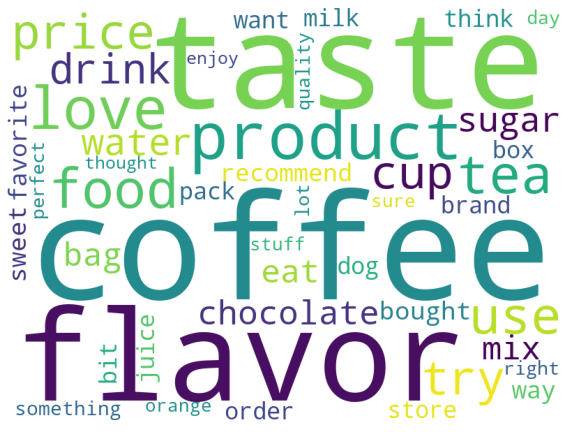

In [ ]:

# from collections import Counter
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_nn))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

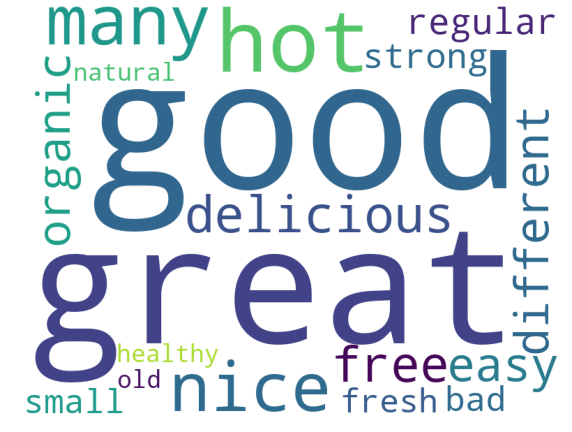

In [ ]:
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_jj))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

### 감성 단어관련 불용어 처리 진행

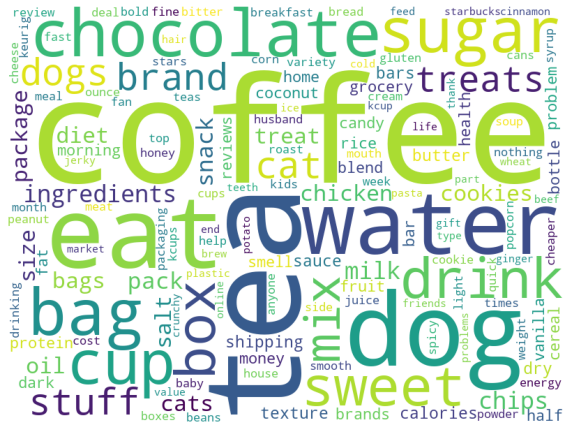

In [ ]:

# from collections import Counter
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_nn))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

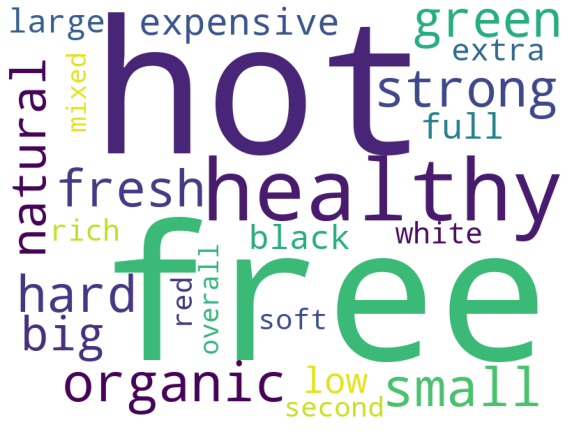

In [ ]:
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_jj))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

### 데이터셋 total 명사 키워드 Top 50 분석

1. coffee, tea 등 drinks 관련 상품이 리뷰가 많은 것을 볼 수 있다.

2. sauce, chips, chocolate 등 상품 키워드가 존재한다.

3. dog, cat 등 반려동물용 상품이 존재하는 것을 알 수 있다.


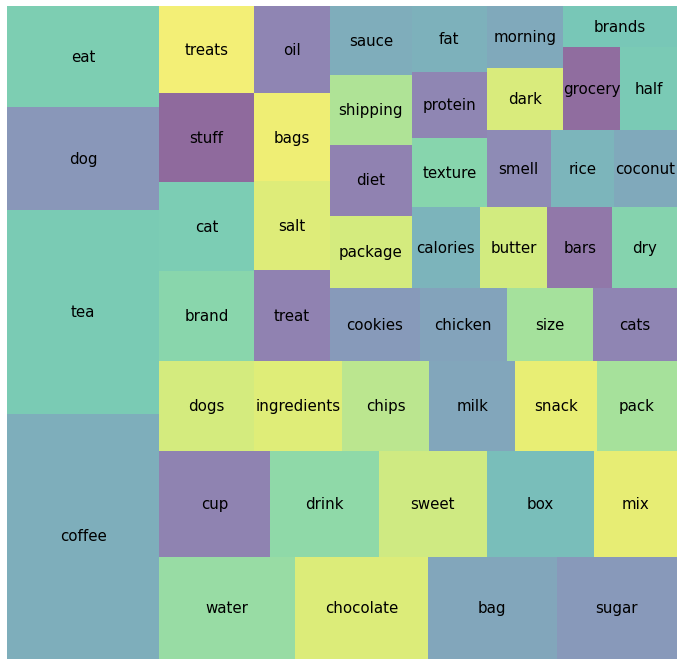

In [ ]:
import squarify
import matplotlib.pyplot as plt


plt.figure(figsize=(12,12))
plt.rc('font', size= 15);
squarify.plot(sizes=words_cnts_pos_nn['counts'], label=words_cnts_pos_nn['words'], alpha=0.6);
plt.axis('off');
plt.show();

### 데이터셋 total 형용사 키워드 Top 25 분석

1. organic, healthy, natural 등 건강기능식품에 대한 관심 및 키워드가 자주 언급되었다.

2. hard, soft, hot 등의 감각 및 지각 관련 키워드가 있음

3. free, low 및 strong, mixed 등 영양소와 관련되어 보이는 키워드가 존재


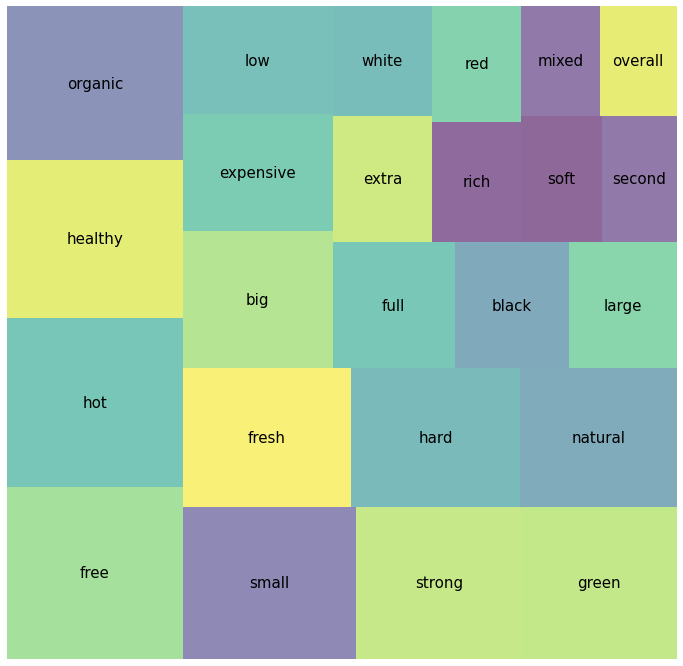

In [ ]:
plt.figure(figsize=(12,12))
plt.rc('font', size= 15);
squarify.plot(sizes=words_cnts_pos_jj['counts'], label=words_cnts_pos_jj['words'], alpha=0.6);
plt.axis('off');
plt.show();

### Word2Vec으로 단어 유사도를 통한 유사단어 TOP 10 

In [ ]:

# 13분
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences =df['keyword'], size = 1000, window = 5, min_count = 0, workers = 4, sg = 1)

In [ ]:
w2v_model.wv.similar_by_word('salted')

[('saltiness', 0.9461536407470703),
 ('caramels', 0.939339280128479),
 ('taking', 0.9333674311637878),
 ('olives', 0.9323548078536987),
 ('saltier', 0.931652307510376),
 ('salsa', 0.9255938529968262),
 ('packet', 0.9246922135353088),
 ('caviar', 0.9224352836608887),
 ('ranch', 0.9185075759887695),
 ('paste', 0.9175365567207336)]

In [ ]:
w2v_model.wv.similar_by_word('dog')

[('frenchie', 0.5774935483932495),
 ('bostons', 0.5754867792129517),
 ('minicongo', 0.5747948884963989),
 ('puppydog', 0.572725236415863),
 ('weimeraner', 0.567723274230957),
 ('vizsla', 0.5605425834655762),
 ('chewz', 0.5597697496414185),
 ('chorkie', 0.5591316223144531),
 ('fostered', 0.5590769648551941),
 ('dogs', 0.5582708716392517)]

## 키워드 생성

### Sentence Transformer - Bert를 이용해 문맥을 인지하는 임베딩으로 키워드를 추출 Best 8개 이내로 생성



In [9]:
from sentence_transformers import SentenceTransformer

# 트랜스포머 모델 생성
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
k_word

[['labrador', 'stew', 'meat', 'canned', 'dog'],
 ['sized', 'salted', 'vendor', 'intended', 'error'],
 ['coated', 'chewy', 'flavorful', 'powdered', 'sugar'],
 ['ingredient', 'root', 'extract', 'believe', 'addition'],
 ['delivery', 'deal', 'assortment', 'lover', 'taffy'],
 ['peppermint', 'watermelon', 'pound', 'five', 'taffy'],
 ['fralinger', 'taffy', 'chewy', 'candies', 'candy'],
 ['taffy', 'soft', 'satisfying', 'amazing', 'chewy'],
 ['rye', 'grass', 'wheatgrass', 'rotate', 'cats'],
 ['healthy', 'feeding', 'small', 'dog', 'puppies']]

In [ ]:
# %%time

from tensorflow.python.types.core import Value
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics.pairwise import cosine_similarity
top_n = 10
k_word, doc =[], []
emb,f1,f2,f3 = [],[],[],[]
for i in range(len(df['Text'])):
  print(i)
  n_gram_range = (1, 1)
  # Extract candidate words/phrases
  try:  
      count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Text'][i]])
      candidates = count.get_feature_names()
      doc_embedding = model.encode([df['Text'][i]])
      candidate_embeddings = model.encode(candidates)
      distances = cosine_similarity(doc_embedding, candidate_embeddings)
      b = [index for index in distances.argsort()[0][-5:] if pos_tag(candidates[index])[0][1] == 'JJ' if pos_tag(candidates[index])[0][1] == 'NN' or pos_tag(candidates[index])[0][1] == 'NNS']
      if len(b) < 3:
        b = [index for index in distances.argsort()[0][-5:]]
      doc.append(doc_embedding)
      emb.append(b)

  except ValueError:
    try:
      count = CountVectorizer(ngram_range=n_gram_range, stop_words='english').fit([df['Text'][i]])
      candidates = count.get_feature_names()
      doc_embedding = model.encode([df['Text'][i]])
      candidate_embeddings = model.encode(candidates)
      distances = cosine_similarity(doc_embedding, candidate_embeddings)
      b = [index for index in distances.argsort()[0][-5:] if pos_tag(candidates[index])[0][1] == 'JJ' if pos_tag(candidates[index])[0][1] == 'NN' or pos_tag(candidates[index])[0][1] == 'NNS']
      if len(b) < 3:
        # a = [candidates1[index] for index in distances1.argsort()[0][-5:]]
        b = [index for index in distances.argsort()[0][-5:]]
      doc.append(doc_embedding)
      emb.append(b)
    except ValueError:
      # k_word.append('No')
      doc.append('')
      emb.append('')
# df['keyword']= k_word
df['emb']= emb
df['doc'] = doc

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
88110
88111
88112
88113
88114
88115
88116
88117
88118
88119
88120
88121
88122
88123
88124
88125
88126
88127
88128
88129
88130
88131
88132
88133
88134
88135
88136
88137
88138
88139
88140
88141
88142
88143
88144
88145
88146
88147
88148
88149
88150
88151
88152
88153
88154
88155
88156
88157
88158
88159
88160
88161
88162
88163
88164
88165
88166
88167
88168
88169
88170
88171
88172
88173
88174
88175
88176
88177
88178
88179
88180
88181
88182
88183
88184
88185
88186
88187
88188
88189
88190
88191
88192
88193
88194
88195
88196
88197
88198
88199
88200
88201
88202
88203
88204
88205
88206
88207
88208
88209
88210
88211
88212
88213
88214
88215
88216
88217
88218
88219
88220
88221
88222
88223
88224
88225
88226
88227
88228
88229
88230
88231
88232
88233
88234
88235
88236
88237
88238
88239
88240
88241
88242
88243
88244
88245
88246
88247
88248
88249
88250
88251
88252
88253
88254
88255
88256
88257
88258
88259
88260
88261
88262
88263
88264
88265
88266
88267
88268
88269
8827

원래 진행은 아래와 같이 두번에 걸쳐 진행해야 하지만, 시간상 tri-gram을 생략하고 진행 위와 같이 진행

In [ ]:
# for i in range(len(df['Text'])):
#   print(i)
#   n_gram_range = (3, 3)
#   # Extract candidate words/phrases
#   try:  
#       count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Text'][i]])

#       candidates = count.get_feature_names()
#       doc_embedding = model.encode([df['Text'][i]])
#       candidate_embeddings = model.encode(candidates)
#       distances = cosine_similarity(doc_embedding, candidate_embeddings)
#       keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

#       n_gram_range1 = (1, 1)
#       count1 = CountVectorizer(ngram_range=n_gram_range1, stop_words=stop_words).fit(keywords)
#       candidates1 = count1.get_feature_names()

#       doc_embedding1 = model.encode(keywords)
#       candidate_embeddings1 = model.encode(candidates1)
#       distances1 = cosine_similarity(doc_embedding1, candidate_embeddings1)
#       a = [candidates1[index] for index in distances1.argsort()[0][-5:] if pos_tag(candidates1[index])[0][1] == 'JJ' if pos_tag(candidates1[index])[0][1] == 'NN' or pos_tag(candidates1[index])[0][1] == 'NNS']
#       b = [index for index in distances1.argsort()[0][-5:] if pos_tag(candidates1[index])[0][1] == 'JJ' if pos_tag(candidates1[index])[0][1] == 'NN' or pos_tag(candidates1[index])[0][1] == 'NNS']
#       if len(a) < 3:
#         a = [candidates1[index] for index in distances1.argsort()[0][-5:]]
        
#       k_word.append(a)
#       emb.append(b)
#   except ValueError:
#     try:
#       count = CountVectorizer(ngram_range=n_gram_range, stop_words='english').fit([df['Text'][i]])
#       candidates = count.get_feature_names()
#       doc_embedding = model.encode([df['Text'][i]])
#       candidate_embeddings = model.encode(candidates)
#       distances = cosine_similarity(doc_embedding, candidate_embeddings)
#       keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

#       n_gram_range1 = (1, 1)
#       count1 = CountVectorizer(ngram_range=n_gram_range1, stop_words='english').fit(keywords)
#       candidates1 = count1.get_feature_names()

#       doc_embedding1 = model.encode(keywords)
#       candidate_embeddings1 = model.encode(candidates1)
#       distances1 = cosine_similarity(doc_embedding1, candidate_embeddings1)
#       a = [candidates1[index] for index in distances1.argsort()[0][-8:] if pos_tag(candidates1[index])[0][1] == 'NN' or pos_tag(candidates1[index])[0][1] == 'NNS' or pos_tag(candidates1[index])[0][1] == 'JJ']
#       if len(a) < 3:
#         a = [candidates1[index] for index in distances1.argsort()[0][-5:]]
#         b = [index for index in distances1.argsort()[0][-5:]]
#       k_word.append(a)
#       emb.append(b)
#     except ValueError:
#       k_word.append('No')
#       emb.append('')
# df['keyword']= k_word
# df['emb']= k_word

In [ ]:
# df.to_csv('reviews_project.csv', header=False, index = False)

### Tokenizer 작성 

모델 입력에 이용할 BertTokenizer를 작성합니다. 

In [ ]:

# Config 설적을 통해 Bert base 모델 가져오기
config = BertConfig.from_pretrained('bert-base-uncased')
config.output_hidden_states = False

# 토크나이저 정의 - Config를 일치시켜 같은 모델에 대한 토크나이저를 가져오기
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased', config = config)

# Bert 모델 가져오기
transformer_model = TFBertModel.from_pretrained('bert-base-uncased', config = config)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Model Architecture 작성


In [ ]:
bert = transformer_model.layers[0]
input_ids = tf.keras.Input(shape = (128, ), name = 'input_ids', dtype = 'int32')
inputs = {'input':input_ids}
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output')
pooled_output = dropout(bert_model, training=False)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model.summary()

Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

### dog, cat 등 반려동물을 키우는 고객을 파악

가능하면 dog과 cat을 나눠서 파악 -> 좀 더 필요한 상품을 추천하기 위함

In [ ]:
# Text에서 고객 파악
def sorting_labels(df):
  labels = []
  for i in df['Text']:
    if (('my dog' in i) or ('My dog' in i) or ('MY dog' in i) or ('MY DOG' in i) or ('my DOG' in i) or ('my Dog' in i)) and (('my cat' in i) or ('My cat' in i) or ('MY cat' in i) or ('MY CAT' in i) or ('my CAT' in i) or ('my Cat' in i)):
      labels.append(3)
    elif ('my dog' in i) or ('My dog' in i) or ('MY dog' in i) or ('MY DOG' in i) or ('my DOG' in i) or ('my Dog' in i):
      labels.append(1)
    elif ('my cat' in i) or ('My cat' in i) or ('MY cat' in i) or ('MY CAT' in i) or ('my CAT' in i) or ('my Cat' in i):
      labels.append(2)
    elif (('tasty' in i) or  ('taste good' in i) or ('yummy' in i)) and (('dog' not in i) or ('Dog' not in i) or ('DOG' not in i) or ('cat' not in i) or ('Cat' not in i) or ('CAT' not in i) or ('puppy' not in i)):
      labels.append(0)
    else:
      labels.append(None)
  df['labels'] = labels
  return df

In [ ]:
# summary에서 고객파악
def sorting_hints(df):
  labels = []

  for i, k in zip(df['Summary'], range(len(df['labels']))):
    if pd.isna(df['labels'][k])==True:
      if (('dog' in i) or ('dog' in i ) or ('dog' in i ) or ('DOG' in i ) or ('DOG' in i ) or ('Dog' in i )) and (('cat' in i ) or ('cat' in i ) or ('cat' in i ) or ('CAT' in i ) or ('CAT' in i ) or ('Cat' in i )):
        df['labels'][k] = 3
      elif ('dog' in i ) or ('dog' in i ) or ('dog' in i ) or ('DOG' in i ) or ('DOG' in i ) or ('Dog' in i ):
        df['labels'][k] = 1
      elif ('cat' in i ) or ('cat' in i ) or ('cat' in i ) or ('CAT' in i ) or ('CAT' in i ) or ('Cat' in i ):
        df['labels'][k] = 2
      elif (('tasty' in i ) or  ('taste good' in i ) or ('yummy' in i )) and (('dog' not in i ) or ('Dog' not in i ) or ('DOG' not in i ) or ('cat' not in i ) or ('Cat' not in i ) or ('CAT' not in i ) or ('puppy' not in i )):
        df['labels'][k] = 0
    else:
      continue
  return df

In [ ]:
sorting_labels(df)
sorting_hints(df)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,dayofweek,r_counts,keyword,labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,Wednesday,1,"['vitality', 'finicky', 'smells', 'labrador', ...",1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Friday,1,"['jumbo', 'unsalted', 'small', 'sized', 'vendo...",NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,Monday,3,"['gelatin', 'pillowy', 'mouthful', 'coated', '...",0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,Monday,3,"['medicinal', 'robitussin', 'cherry', 'ingredi...",NaN
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Sunday,2,"['quick', 'wide', 'delivery', 'deal', 'lover']",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09,Wednesday,1,"['sesame', 'chicken', 'husband', 'recipes', 'r...",NaN
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09,Friday,9,"['notes', 'small', 'thanks', 'weak', 'disappoi...",NaN
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,Tuesday,1,"['compare', 'train', 'smell', 'preservatives',...",NaN
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,Tuesday,2,"['rewarding', 'grooming', 'sweet', 'wet', 'tre...",NaN


In [ ]:
df['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
#######
######## 텍스트에 dog이 없어도 label을 dog으로 찾을 수 있게 한다.

df_bert= df[(((df['Summary'].str.contains('dog')) |
    (df['Summary'].str.contains('Dog')) |
    (df['Summary'].str.contains('DOG'))) &
    ~((df['Text'].str.contains('dog')) |
    (df['Text'].str.contains('Dog')) |
    (df['Text'].str.contains('DOG')))) |

    (((df['Summary'].str.contains('cat')) |
    (df['Summary'].str.contains('Cat')) |
    (df['Summary'].str.contains('CAT'))) &
    ~((df['Text'].str.contains('cat')) |
    (df['Text'].str.contains('Cat')) |
    (df['Text'].str.contains('CAT')))) |

    ((df['labels']== 0) &
    ~((df['Text'].str.contains('cat')) |
    (df['Text'].str.contains('Cat')) |
    (df['Text'].str.contains('CAT')) |
    (df['Text'].str.contains('dog')) |
    (df['Text'].str.contains('Dog')) |
    (df['Text'].str.contains('DOG')))) |
    
    (df['labels']==3)]


In [ ]:
df['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
df_bert['labels'].value_counts()

0.0    37109
1.0     2811
2.0      962
3.0      420
Name: labels, dtype: int64

### Under Sampling

고양이와 강아지 모두 키우는 사람이 수가 적으므로 해당 수에 맞춰서 학습시킨다.

In [ ]:
df_bert_1 = df_bert[df_bert['labels']==1][:300]
df_bert_2 = df_bert[df_bert['labels']==2][:300]
df_bert_0 = df_bert[df_bert['labels']==0][:300]
df_bert_3 = df_bert[df_bert['labels']==3][:300]
df_bert_train = pd.concat([df_bert_1,df_bert_2,df_bert_3,df_bert_0])
df_bert_train = df_bert_train.sample(frac=1)

In [ ]:
df_bert_11 = df_bert[df_bert['labels']==1][300:420]
df_bert_22 = df_bert[df_bert['labels']==2][300:420]
df_bert_00 = df_bert[df_bert['labels']==0][300:420]
df_bert_33 = df_bert[df_bert['labels']==3][300:420]
df_bert_val = pd.concat([df_bert_11,df_bert_22,df_bert_33,df_bert_00])
df_bert_val = df_bert_val.sample(frac=1)

In [ ]:
df_bert_111 = df_bert[df_bert['labels']==1][420:5420]
df_bert_222 = df_bert[df_bert['labels']==2][420:5420]
df_bert_000 = df_bert[df_bert['labels']==0][420:5420]
# df_bert_33 = df_bert[df_bert['labels']==3][420:5420]
df_bert_test = pd.concat([df_bert_111,df_bert_222,df_bert_000])
df_bert_test = df_bert_test.sample(frac=1)

In [ ]:
df[df['labels'].notnull()]['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
%%time

optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-05,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x= tokenizer(
    text = df_bert_train['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
     
)

early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)


history = model.fit(x['input_ids'],df_bert_train['labels'], validation_split=0.2, batch_size = 64, epochs=10, callbacks=[early])

Epoch 1/10
15/15 [==============================] - 32s 1s/step - loss: 1.3387 - accuracy: 0.3406 - val_loss: 1.3053 - val_accuracy: 0.3958
Epoch 2/10
15/15 [==============================] - 14s 972ms/step - loss: 1.2403 - accuracy: 0.4219 - val_loss: 1.1563 - val_accuracy: 0.4917
Epoch 3/10
15/15 [==============================] - 14s 972ms/step - loss: 0.9695 - accuracy: 0.5698 - val_loss: 0.7455 - val_accuracy: 0.6917
Epoch 4/10
15/15 [==============================] - 14s 973ms/step - loss: 0.6197 - accuracy: 0.7635 - val_loss: 0.4728 - val_accuracy: 0.8417
Epoch 5/10
15/15 [==============================] - 14s 973ms/step - loss: 0.3886 - accuracy: 0.8823 - val_loss: 0.4667 - val_accuracy: 0.8167
Epoch 6/10
15/15 [==============================] - 14s 973ms/step - loss: 0.2298 - accuracy: 0.9406 - val_loss: 0.4369 - val_accuracy: 0.8458
Epoch 7/10
15/15 [==============================] - 14s 953ms/step - loss: 0.1198 - accuracy: 0.9792 - val_loss: 0.4439 - val_accuracy: 0.8458
Ep

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
x1= tokenizer(
    text = df_bert_val['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
)

pred = model.predict(x1['input_ids'])
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_val['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_val['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_val['labels'],pred_result))
print('classification report \n', classification_report(df_bert_val['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.890
confusion matrix 
 [[111   0   9   0]
 [  1 108   9   2]
 [ 13  13  90   4]
 [  0   1   1 118]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.89      0.93      0.91       120
       1 강아지       0.89      0.90      0.89       120
       2 고양이       0.83      0.75      0.79       120
 3 강아지 + 고양이       0.95      0.98      0.97       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



### 재학습

In [ ]:
df_bert_1111 = df[df['labels']==1][:10000]
df_bert_2222 = df[df['labels']==2][:10000]
df_bert_0000 = df[df['labels']==0][:10000]
# df_bert_3 = df[df['labels']==3][:300]
df_bert_train2 = pd.concat([df_bert_1111,df_bert_2222,df_bert_0000])
df_bert_train2 = df_bert_train2.sample(frac=1)

In [ ]:
df_bert_11111 = df[df['labels']==1][10000:]
df_bert_22222 = df[df['labels']==2][10000:]
df_bert_00000 = df[df['labels']==0][10000:]
df_bert_33333 = df[df['labels']==3]
df_bert_test2 = pd.concat([df_bert_11111,df_bert_22222,df_bert_33333,df_bert_00000])
df_bert_test2 = df_bert_test2.sample(frac=1)

In [ ]:
%%time

optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-05,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metric)

x2= tokenizer(
    text = df_bert_train2['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
     
)

early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)


history = model.fit(x2['input_ids'],df_bert_train2['labels'], validation_split=0.2, batch_size = 64, initial_epoch= history.epoch[-1], epochs=20, callbacks=[early])

Epoch 9/20
375/375 [==============================] - 371s 953ms/step - loss: 0.1222 - accuracy: 0.9625 - val_loss: 0.0831 - val_accuracy: 0.9780
Epoch 10/20
375/375 [==============================] - 354s 944ms/step - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.0732 - val_accuracy: 0.9810
Epoch 11/20
375/375 [==============================] - 353s 943ms/step - loss: 0.0396 - accuracy: 0.9893 - val_loss: 0.0742 - val_accuracy: 0.9813
Epoch 12/20
375/375 [==============================] - 354s 943ms/step - loss: 0.0293 - accuracy: 0.9934 - val_loss: 0.0708 - val_accuracy: 0.9817
Epoch 13/20
375/375 [==============================] - 353s 942ms/step - loss: 0.0227 - accuracy: 0.9947 - val_loss: 0.0725 - val_accuracy: 0.9827
Epoch 14/20
375/375 [==============================] - 353s 943ms/step - loss: 0.0186 - accuracy: 0.9959 - val_loss: 0.0774 - val_accuracy: 0.9827
Epoch 15/20
375/375 [==============================] - 354s 943ms/step - loss: 0.0153 - accuracy: 0.9968 - val_loss: 0.

#### 과적합일 수 있으므로 불균형 대용량 테스트셋 생성

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
X= tokenizer(
    text = df_bert_test2['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
)

pred = model.predict(X['input_ids'])
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_test2['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_test2['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_test2['labels'],pred_result))
print('classification report \n', classification_report(df_bert_test2['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.974
confusion matrix 
 [[28485   174   409     0]
 [  215 25408   162     0]
 [  178    54  7233     0]
 [    1   179   240     0]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.99      0.98      0.98     29068
       1 강아지       0.98      0.99      0.98     25785
       2 고양이       0.90      0.97      0.93      7465
 3 강아지 + 고양이       0.00      0.00      0.00       420

    accuracy                           0.97     62738
   macro avg       0.72      0.73      0.73     62738
weighted avg       0.97      0.97      0.97     62738



### SMOTE를 통한 Over Sampling

K-MEANS 군집화를 이용해 군집 내 랜덤 샘플 생성

In [ ]:
df_bert['labels'].value_counts()

0.0    37109
1.0     2811
2.0      962
3.0      420
Name: labels, dtype: int64

In [ ]:
df_bert_1 = df_bert[df_bert['labels']==1][:800]
df_bert_2 = df_bert[df_bert['labels']==2][:800]
df_bert_0 = df_bert[df_bert['labels']==0][:800]
df_bert_3 = df_bert[df_bert['labels']==3][:300]
df_bert_train1 = pd.concat([df_bert_1,df_bert_2,df_bert_3,df_bert_0])
df_bert_train1 = df_bert_train1.sample(frac=1)

In [ ]:
df_bert_11 = df_bert[df_bert['labels']==1][800:920]
df_bert_22 = df_bert[df_bert['labels']==2][800:920]
df_bert_00 = df_bert[df_bert['labels']==0][800:920]
df_bert_33 = df_bert[df_bert['labels']==3][300:420]
df_bert_val1 = pd.concat([df_bert_11,df_bert_22,df_bert_33,df_bert_00])
df_bert_val1 = df_bert_val1.sample(frac=1)

In [ ]:
df_bert_train1.drop(columns=['ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator','date', 'keyword'], inplace = True)
df_bert_val1.drop(columns=['ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator','date', 'keyword'], inplace = True)

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder

def berttok(df, col):

  df[col]= np.array(tokenizer(
      text = df[col].to_list(),
      add_special_tokens=True,
      max_length = 128,
      truncation = True,
      padding = True,
      # return_tensors='tf',
      return_token_type_ids=False,
      # returen_attention_mask=False,
      verbose = True)['input_ids'])

text = 'Text'
summary = 'Summary'
berttok(df_bert_train1, text)
berttok(df_bert_train1, summary)
berttok(df_bert_val1, text)
berttok(df_bert_val1, summary)

encoder = OrdinalEncoder(cols=['ProductId','UserId','dayofweek'])
bert_train_encoded = encoder.fit_transform(df_bert_train1)
bert_val_encoded = encoder.transform(df_bert_val1)

scaler = StandardScaler()
bert_train_scaled = scaler.fit_transform(bert_train_encoded)
bert_val_scaled = scaler.transform(bert_val_encoded)


pca = PCA(n_components = 2)           # 2차원으로 시각화를 진행할 것이므로 2개로 설정한다.
pca.fit(bert_train_scaled)             
df_p = pca.transform(bert_train_scaled)
df_p = pd.DataFrame(df_p, columns = ['PC1','PC2']) #PCA진행 한 두 개의 값을 column으로 데이터프레임화 시킨다.
df_p

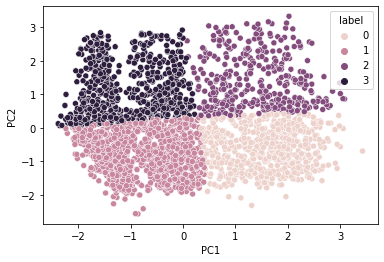

In [ ]:
# 군집 시각화
sns.scatterplot(data = df_p, x = 'PC1',y = 'PC2', hue = 'label'); 

In [ ]:
# SMOTE 진행
smote = BorderlineSMOTE()
data,label = smote.fit_resample(df_p, labels)

In [ ]:
# %%time

bert = transformer_model.layers[0]
input_ids = tf.keras.Input(shape = (10, ), name = 'input_ids', dtype = 'int32')
inputs = {'input':input_ids}
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output')
pooled_output = dropout(bert_model, training=False)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model1= tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model1.summary()


optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-05,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

model1.compile(optimizer = optimizer, loss = loss, metrics = metric)

early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)



Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 pooled_output (Dropout)     (None, 768)               0         
                                                                 
 output (Dense)              (None, 4)                 3076      
                                                                 
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


In [ ]:
data

In [ ]:
history = model1.fit(data,label, validation_split=0.2, batch_size = 64, epochs=10, callbacks=[early])

### Scaling 하지 않고 SMOTE 진행

In [ ]:
x3= tokenizer(
  text = df_bert_train1['Text'].to_list(),
  add_special_tokens=True,
  max_length = 128,
  truncation = True,
  padding = True,
  return_tensors='tf',
  return_token_type_ids=False,
  # returen_attention_mask=False,
  verbose = True)['input_ids']


In [ ]:
kmeans = KMeans().fit(x3)
labels = kmeans.predict(x3)
smote = BorderlineSMOTE()
data,label = smote.fit_resample(x3,df_bert_train1['labels'])

In [ ]:
bert = transformer_model.layers[0]
input_ids = tf.keras.Input(shape = (128, ), name = 'input_ids', dtype = 'int32')
inputs = {'input':input_ids}
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output')
pooled_output = dropout(bert_model, training=False)
outputs = tf.keras.layers.Dense(4, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model2= tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model2.summary()


optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-06,
                                     epsilon=1e-08,
                                     decay=0.01,
                                     clipnorm=1.0)
loss = 'sparse_categorical_crossentropy'
metric = ['accuracy']

early = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss', patience= 3)

model2.compile(optimizer = optimizer, loss = loss, metrics = metric)

Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 128)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

In [ ]:
model2.fit(data,label, validation_split=0.2, batch_size = 64, epochs=10, callbacks=[early])

Epoch 1/10
40/40 [==============================] - 58s 991ms/step - loss: 1.1316 - accuracy: 0.6559 - val_loss: 1.5027 - val_accuracy: 0.4766
Epoch 2/10
40/40 [==============================] - 37s 936ms/step - loss: 0.6938 - accuracy: 0.9219 - val_loss: 1.5424 - val_accuracy: 0.4703
Epoch 3/10
40/40 [==============================] - 37s 936ms/step - loss: 0.4960 - accuracy: 0.9324 - val_loss: 1.5888 - val_accuracy: 0.4766
Epoch 4/10
40/40 [==============================] - 40s 1000ms/step - loss: 0.3835 - accuracy: 0.9461 - val_loss: 1.6445 - val_accuracy: 0.4766


In [ ]:
x4= tokenizer(
text = df_bert_val1['Text'].to_list(),
add_special_tokens=True,
max_length = 128,
truncation = True,
padding = True,
return_tensors='tf',
return_token_type_ids=False,
# returen_attention_mask=False,
verbose = True)['input_ids']

kmeans = KMeans().fit(x4)
labels = kmeans.predict(x4)
smote = BorderlineSMOTE()
data,label = smote.fit_resample(x4, df_bert_val1['labels'])

model2.evaluate(x4, df_bert_val1)

15/15 [==============================] - 4s 146ms/step - loss: 0.4508 - accuracy: 0.8896


[0.4508122503757477, 0.8895833492279053]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pred = model2.predict(data)
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(label,pred_result)))
# print("f1_score \n",f1_score(label,pred_result))
print("confusion matrix \n",confusion_matrix(label,pred_result))
print('classification report \n', classification_report(label, pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.890
confusion matrix 
 [[100   3  17   0]
 [  1 108   9   2]
 [  8   5 102   5]
 [  1   1   1 117]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.91      0.83      0.87       120
       1 강아지       0.92      0.90      0.91       120
       2 고양이       0.79      0.85      0.82       120
 3 강아지 + 고양이       0.94      0.97      0.96       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pred = model2.predict(x4)
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_val1['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_val1['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_val1['labels'],pred_result))
print('classification report \n', classification_report(df_bert_val1['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.890
confusion matrix 
 [[100   3  17   0]
 [  1 108   9   2]
 [  8   5 102   5]
 [  1   1   1 117]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.91      0.83      0.87       120
       1 강아지       0.92      0.90      0.91       120
       2 고양이       0.79      0.85      0.82       120
 3 강아지 + 고양이       0.94      0.97      0.96       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



### 최종 SMOTE test셋 검증

In [ ]:
df_bert_test = df.drop(index= df_bert['Id'].index)

In [ ]:
df['labels'].value_counts()

0.0    39068
1.0    35785
2.0    17465
3.0      420
Name: labels, dtype: int64

In [ ]:
df_bert_111 = df_bert_test[df_bert_test['labels']==1][:10000]
df_bert_222 = df_bert_test[df_bert_test['labels']==2][:10000]
df_bert_000 = df_bert_test[df_bert_test['labels']==0][:10000]
# df_bert_33 = df_bert_test[df_bert_test['labels']==3][300:420]
df_bert_test1 = pd.concat([df_bert_111,df_bert_222,df_bert_000])
df_bert_test1 = df_bert_test1.sample(frac=1)

In [ ]:
x5= tokenizer(
text = df_bert_test1['Text'].to_list(),
add_special_tokens=True,
max_length = 128,
truncation = True,
padding = True,
return_tensors='tf',
return_token_type_ids=False,
# returen_attention_mask=False,
verbose = True)['input_ids']


model2.evaluate(x5, df_bert_test1['labels'])

687/687 [==============================] - 119s 169ms/step - loss: 1.9562 - accuracy: 0.1402


[1.9561833143234253, 0.14021585881710052]

In [ ]:
pred = model2.predict(x5)
# pred_opt = pred >= 0.5

pred_result = [np.argmax(pred[i]) for i in range(len(pred))]
len(pred_result)


print("accuracy: {:.3f}".format(accuracy_score(df_bert_test1['labels'],pred_result)))
# print("f1_score \n",f1_score(df_bert_test1['labels'],pred_result))
print("confusion matrix \n",confusion_matrix(df_bert_test1['labels'],pred_result))
print('classification report \n', classification_report(df_bert_test1['labels'], pred_result, target_names = ['0 없음','1 강아지','2 고양이','3 강아지 + 고양이']))

accuracy: 0.140
confusion matrix 
 [[1376   20  285  278]
 [ 117  223   96 9564]
 [ 195   42 1480 8283]
 [   0    0    0    0]]
classification report 
               precision    recall  f1-score   support

        0 없음       0.82      0.70      0.75      1959
       1 강아지       0.78      0.02      0.04     10000
       2 고양이       0.80      0.15      0.25     10000
 3 강아지 + 고양이       0.00      0.00      0.00         0

    accuracy                           0.14     21959
   macro avg       0.60      0.22      0.26     21959
weighted avg       0.79      0.14      0.20     21959



### 최종 카테고리 분류 진행

위에서 학습한 내용으로 예측을 하여 자동으로 반려동물 유무 카테고리 라벨링을 한다.

In [ ]:
X_df= tokenizer(
    text = df['Text'].to_list(),
    add_special_tokens=True,
    max_length = 128,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True
)
pred_df = model.predict(X_df['input_ids'])
pred_result_df = [np.argmax(pred_df[i]) for i in range(len(pred_df))]


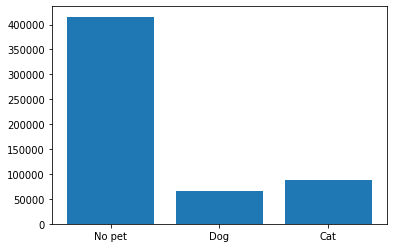

In [ ]:
plt.bar(df['pet'].value_counts().index, df['pet'].value_counts().values)
plt.xticks(df['pet'].value_counts().index, ['No pet','Cat','Dog'])
plt.show();


### 결과 검토

키우지 않는 사람을 고양이나 강아지로 분류할 순 있지만, 

결과로 보아 고양이가 강아지보다 관련 카테고리가 더 많이 분류 되어 잘못 되었음을 알 수 있다.

자칫 고양이를 키우지 않는 많은 고객들에게 추천할 확률이 높으므로 개선 필요:

- 텍스트 전처리를 통해 좀 더 성능을 높여본다.
- 3번 카테고리를 없애거나 카테고리를 통합해 지도학습 진행 시 학습량 자체를 높여야 한다.

In [ ]:
df['pet'].value_counts()

0    415653
2     87166
1     65635
Name: pet, dtype: int64

In [ ]:
df.to_csv('reviews_project2.csv', index = False)

## DCN 모델링 (추후 업데이트 필요)

In [ ]:
df2 = df[300000:]

In [ ]:
df1['Text']= tokenizer(
    text = df1['Text'].to_list(),
    add_special_tokens=True,
    max_length = 64,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True)['input_ids']

In [ ]:
df2['Text']= tokenizer(
    text = df2['Text'].to_list(),
    add_special_tokens=True,
    max_length = 64,
    truncation = True,
    padding = True,
    return_tensors='tf',
    return_token_type_ids=False,
    # returen_attention_mask=False,
    verbose = True)['input_ids']